<a id="toc"></a>
# Advanced Lane Finding

Each code cell below is has a markup cell that preceeds it and provides a title for the code cell.

<a id="chessboard"></a>
## Find Chessboard Corners On A Number Of Calibration Images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

rows = 6
cols = 9
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((rows*cols,3), np.float32)
objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (cols,rows), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

print("Chessboard corners detects completed")

Chessboard corners detects completed


<a id="calibrate"></a>
## Calibrate Camera

In [2]:
import pickle
def savePickle(mtx,dist):
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )

img_size = (1280,720)
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
savePickle(mtx,dist)
print("Camer calibration completed")

Camer calibration completed


<a id="testCalibration"></a>
## Test Camera Calibration With Images

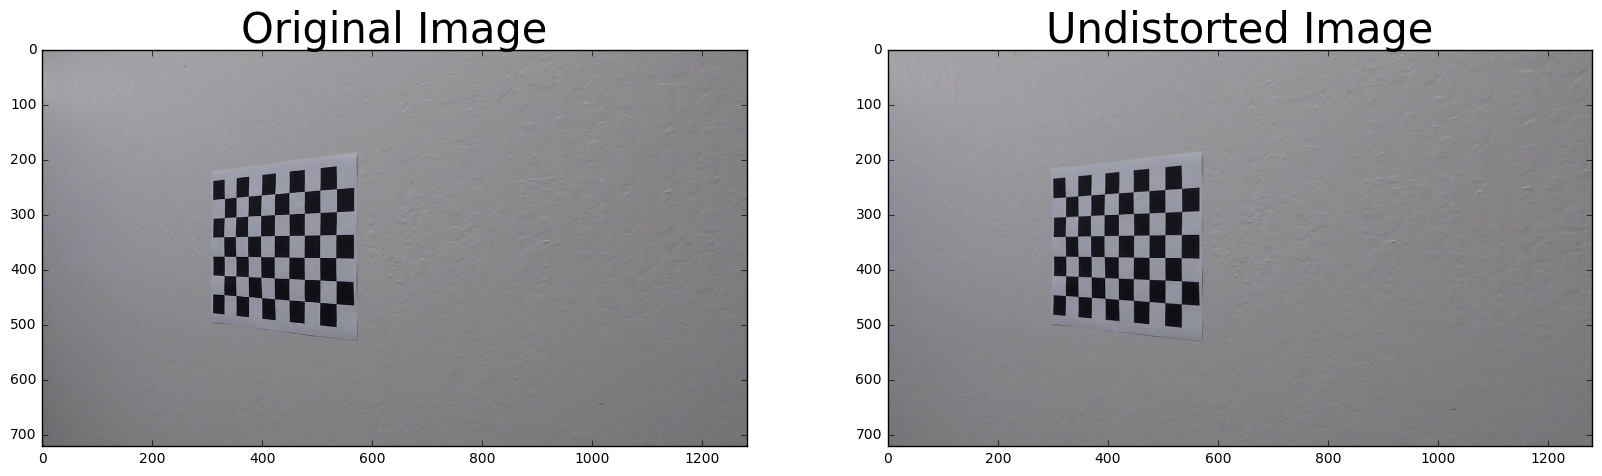

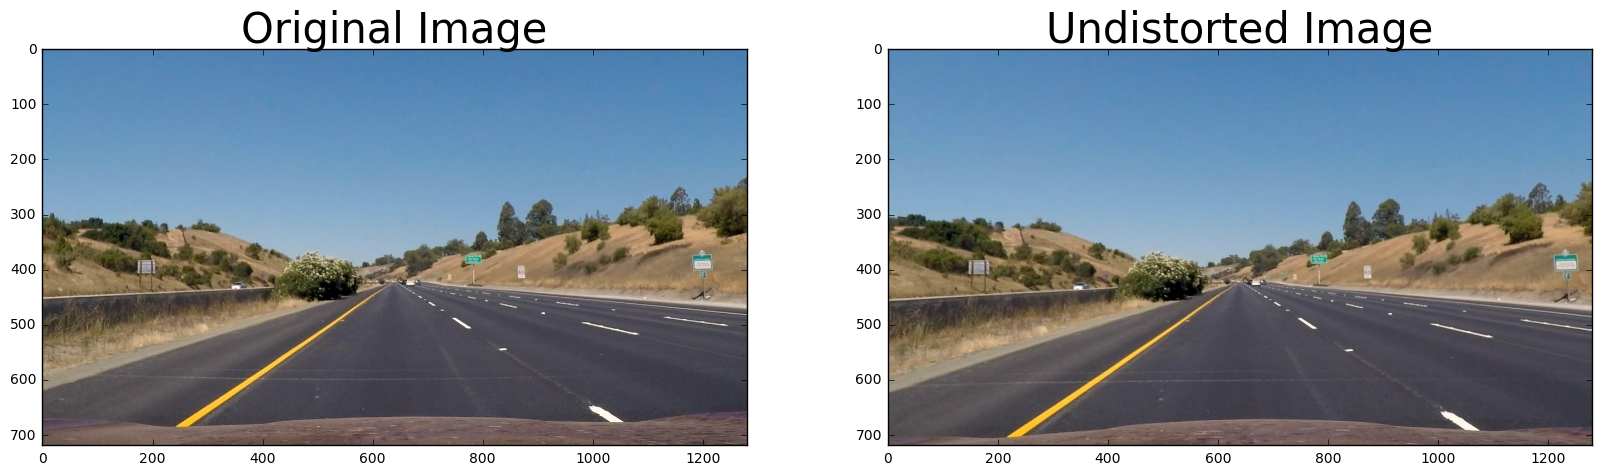

Finished undistorting and showing images


In [3]:
def showImages(ori, dst):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(ori)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.show()

def undistortAndShowImage(file, dist_pickle):
    img = cv2.imread(file)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.undistort(rgb, mtx, dist, None, mtx)
    showImages(rgb,dst)
    dstf = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
    cv2.imwrite('output_images/' + file.split('/')[1], dstf)
    
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
undistortAndShowImage('camera_cal/calibration7.jpg', dist_pickle);
undistortAndShowImage('test_images/straight_lines1.jpg', dist_pickle);
print("Finished undistorting and showing images")

<a id="thresholds"></a>
## Threshold binary image creating via color transform and gradient

color transfrom and gradient - start


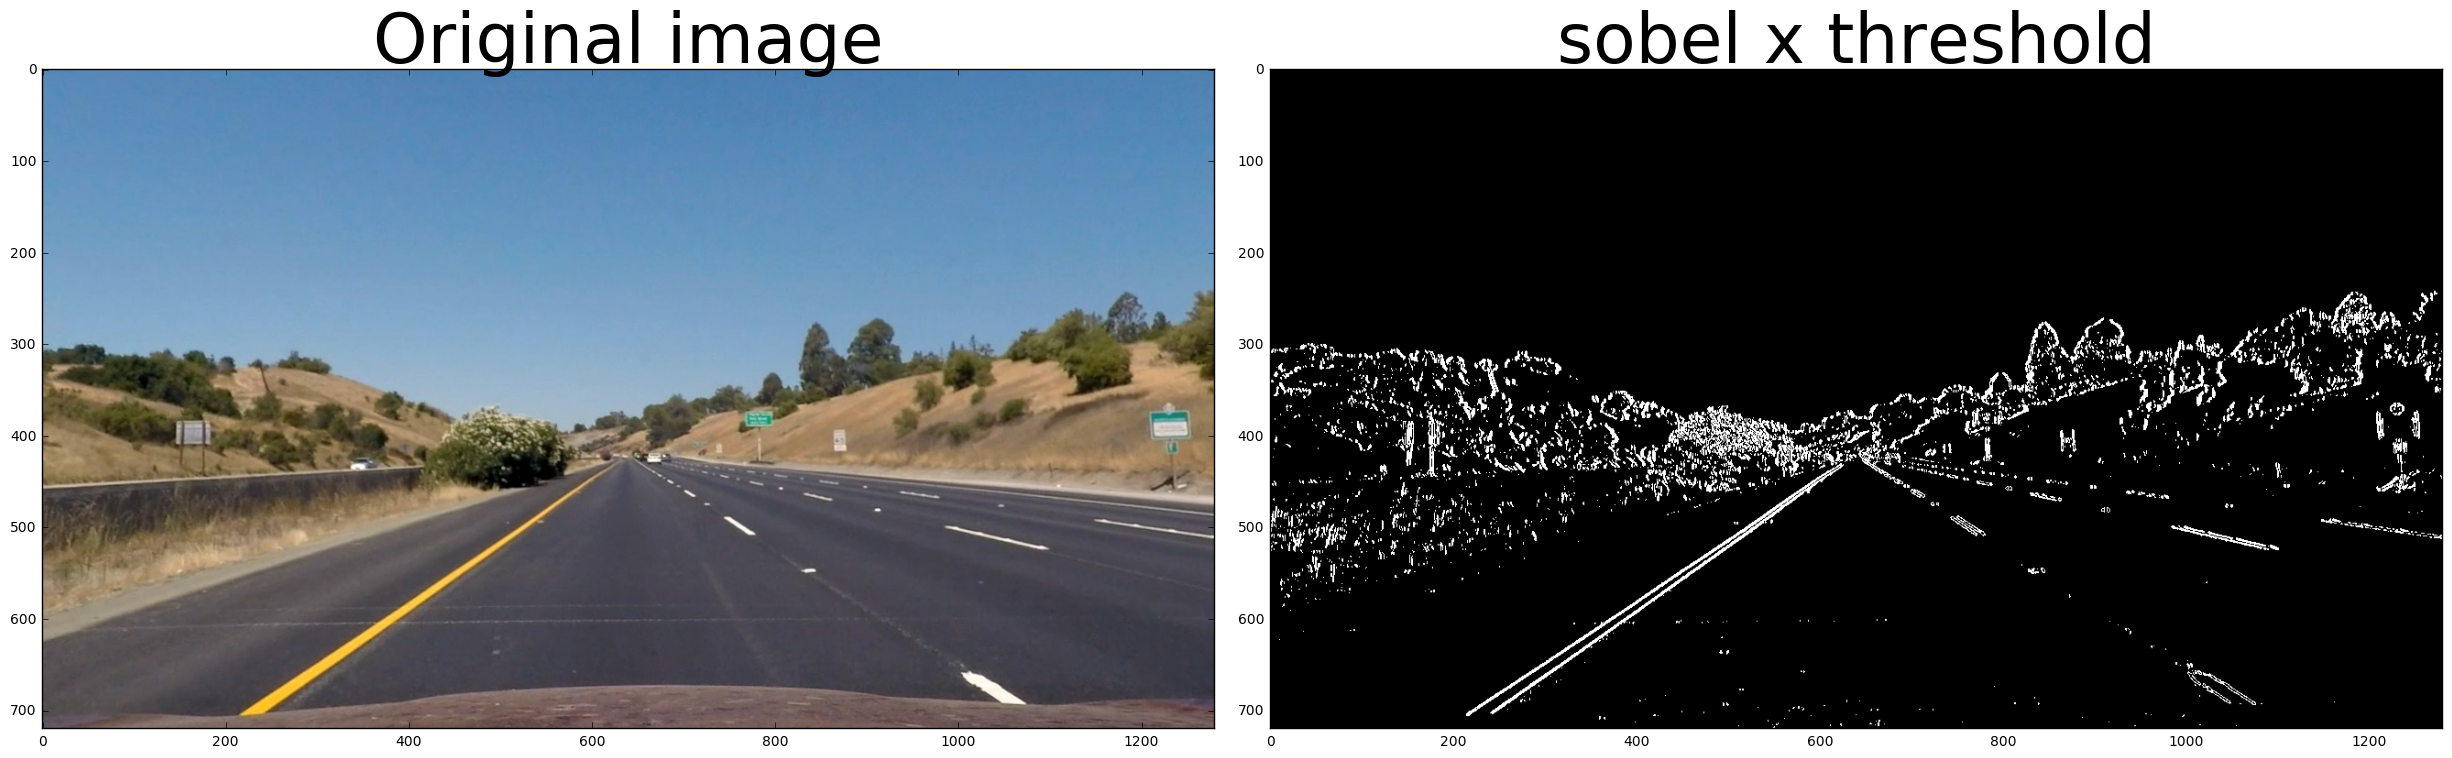

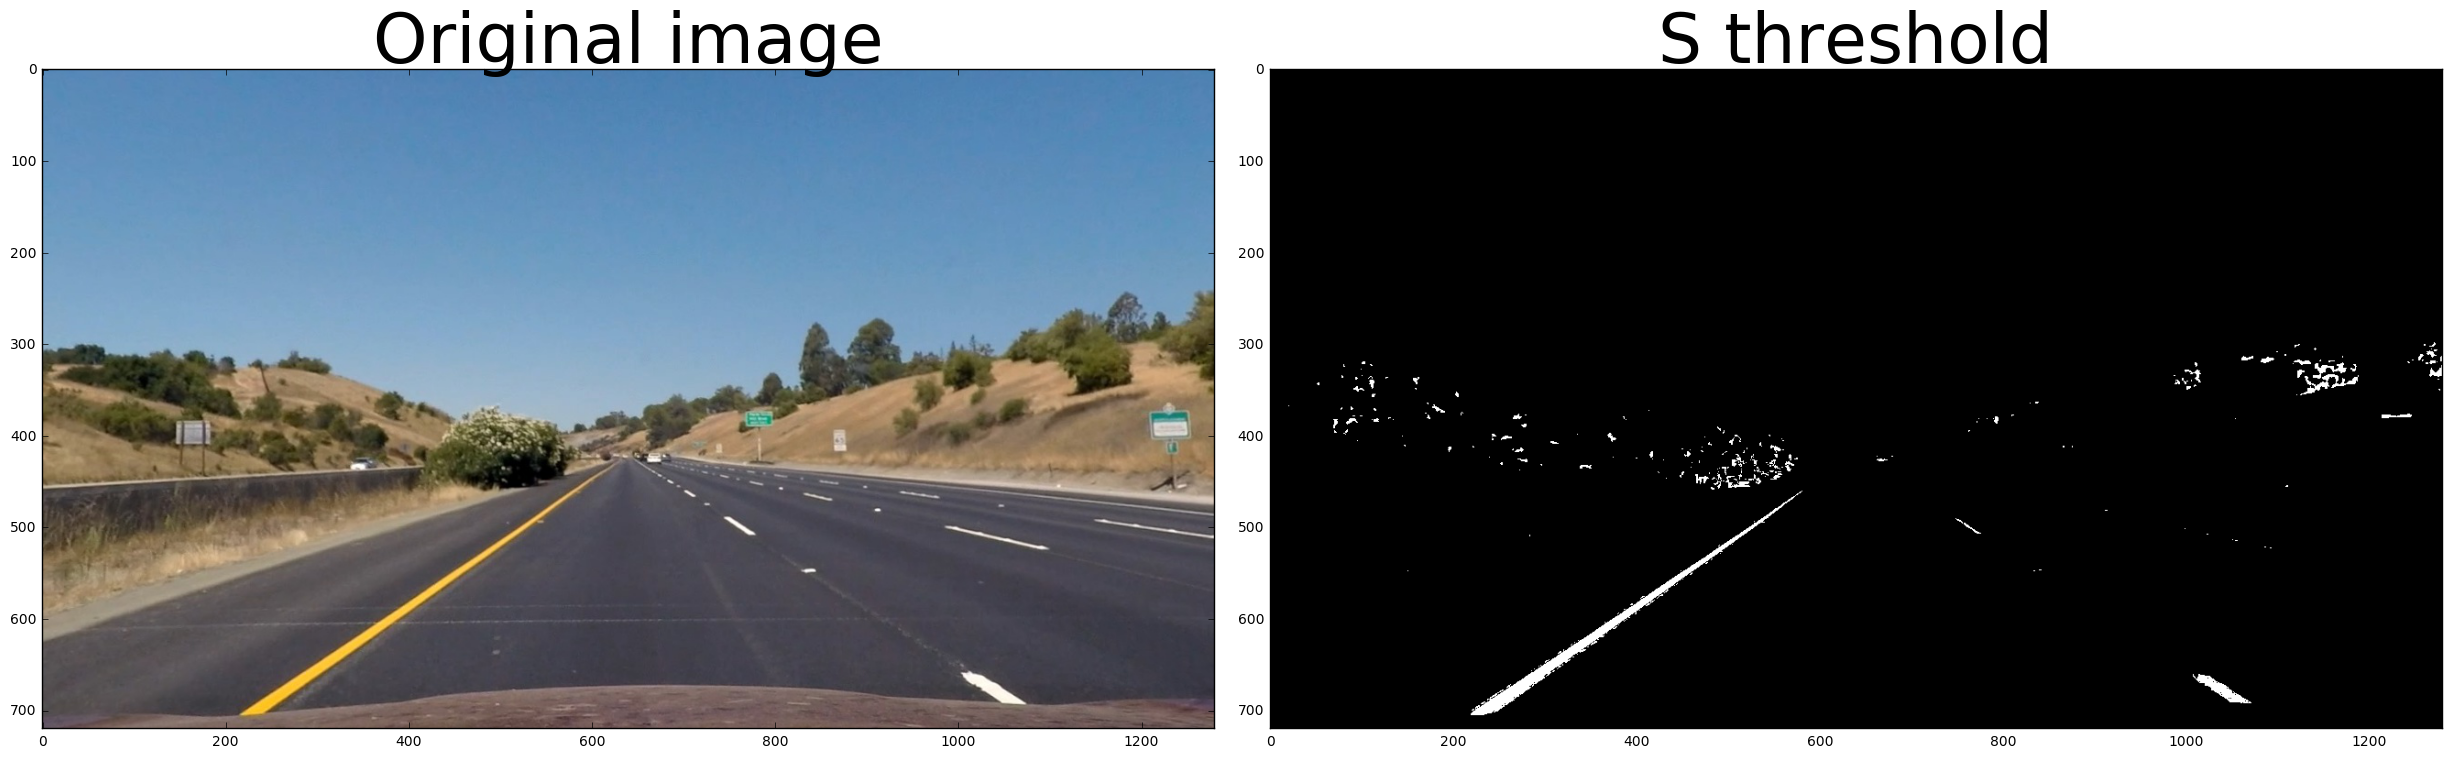

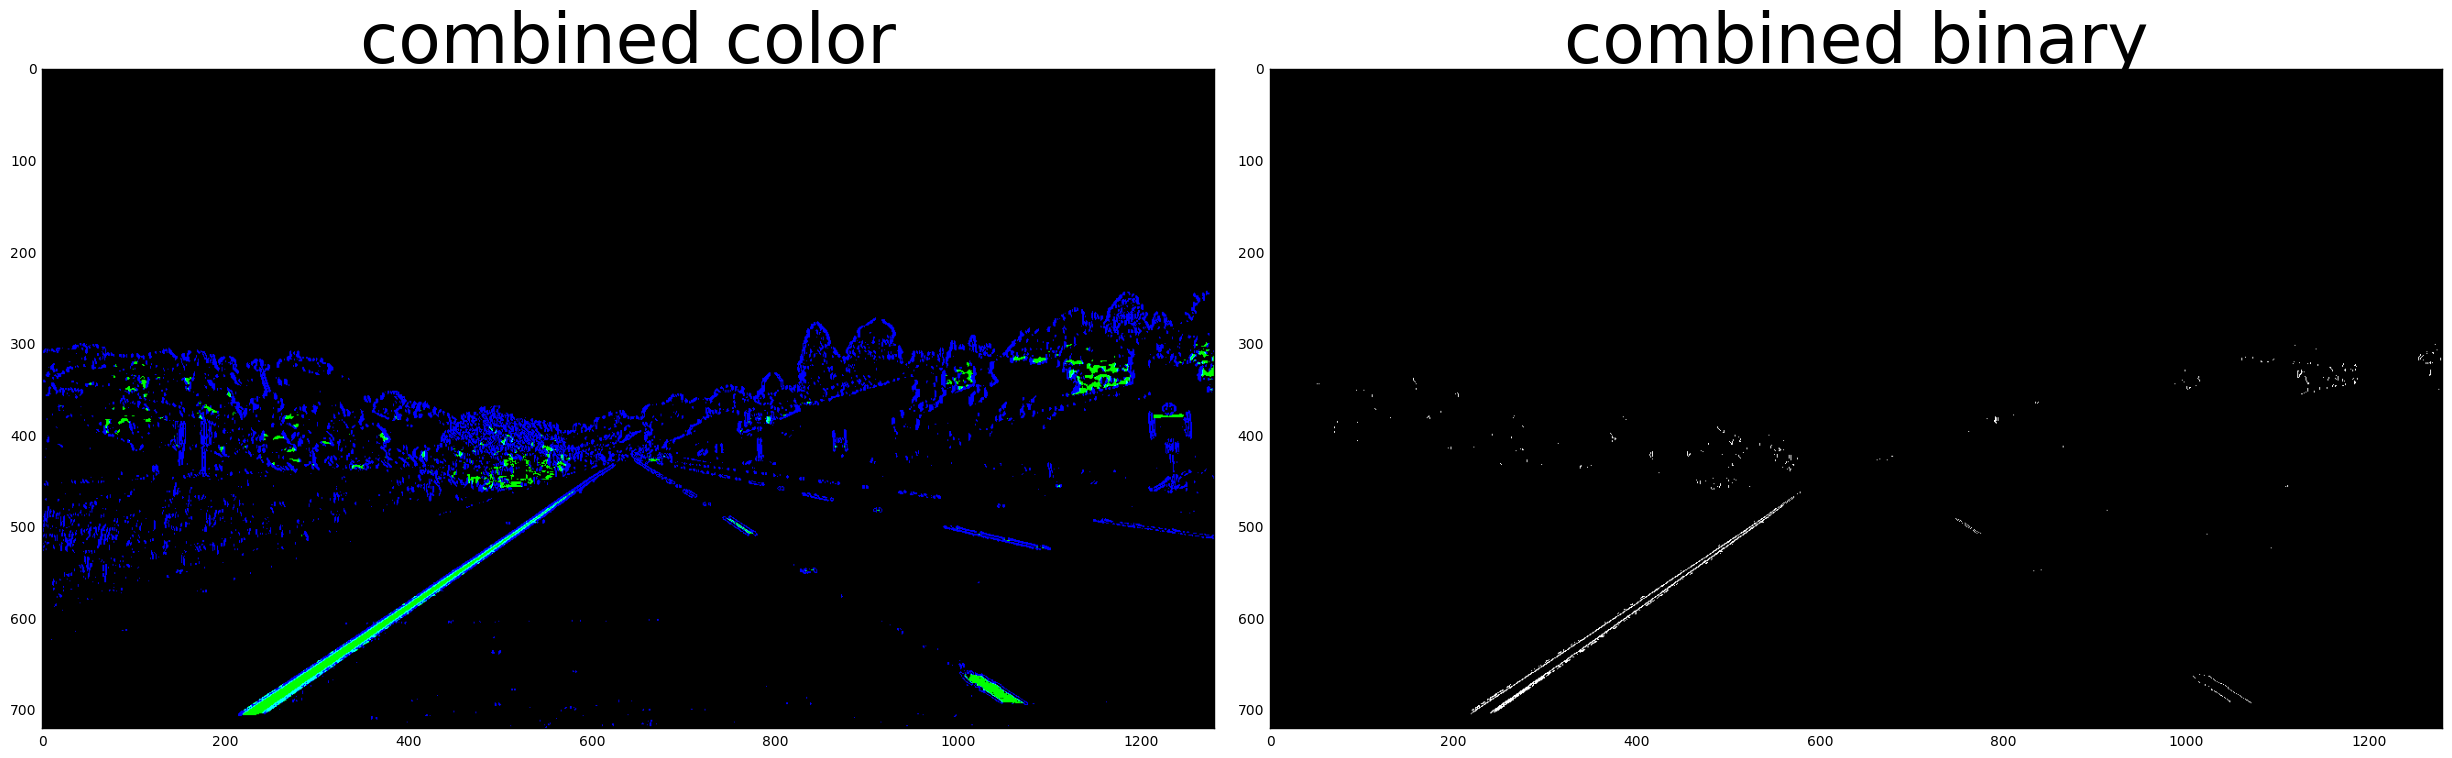

True

In [4]:
print("color transfrom and gradient - start")
def plot(img1, img2, name1, name):
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(name1, fontsize=50)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(name, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show() 

img = cv2.imread('output_images/straight_lines1.jpg')
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]

s_thresh_min = 150
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

color_binary = np.dstack((sxbinary, s_binary,  np.zeros_like(sxbinary)))

combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) & (sxbinary == 1)] = 1

o = "Original image"
plot(img,sxbinary,o,"sobel x threshold")
plot(img,s_binary,o,"S threshold")
plot(color_binary*255,combined_binary,"combined color","combined binary")

cv2.imwrite('output_images/' + "binary_sobel_x" + ".jpg", cv2.cvtColor(sxbinary*255, cv2.COLOR_GRAY2RGB))
cv2.imwrite('output_images/' + "binary_hls_s" + ".jpg", cv2.cvtColor(s_binary*255, cv2.COLOR_GRAY2RGB))
cv2.imwrite('output_images/' + "binary_sx" + ".jpg", cv2.cvtColor(combined_binary*255, cv2.COLOR_GRAY2RGB))
cv2.imwrite('output_images/' + "binary_sx_color" + ".jpg", color_binary*255)

<a id="perspectiveTransform"></a>
## Perspective Transform

[[  585.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  695.           460.        ]] [[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


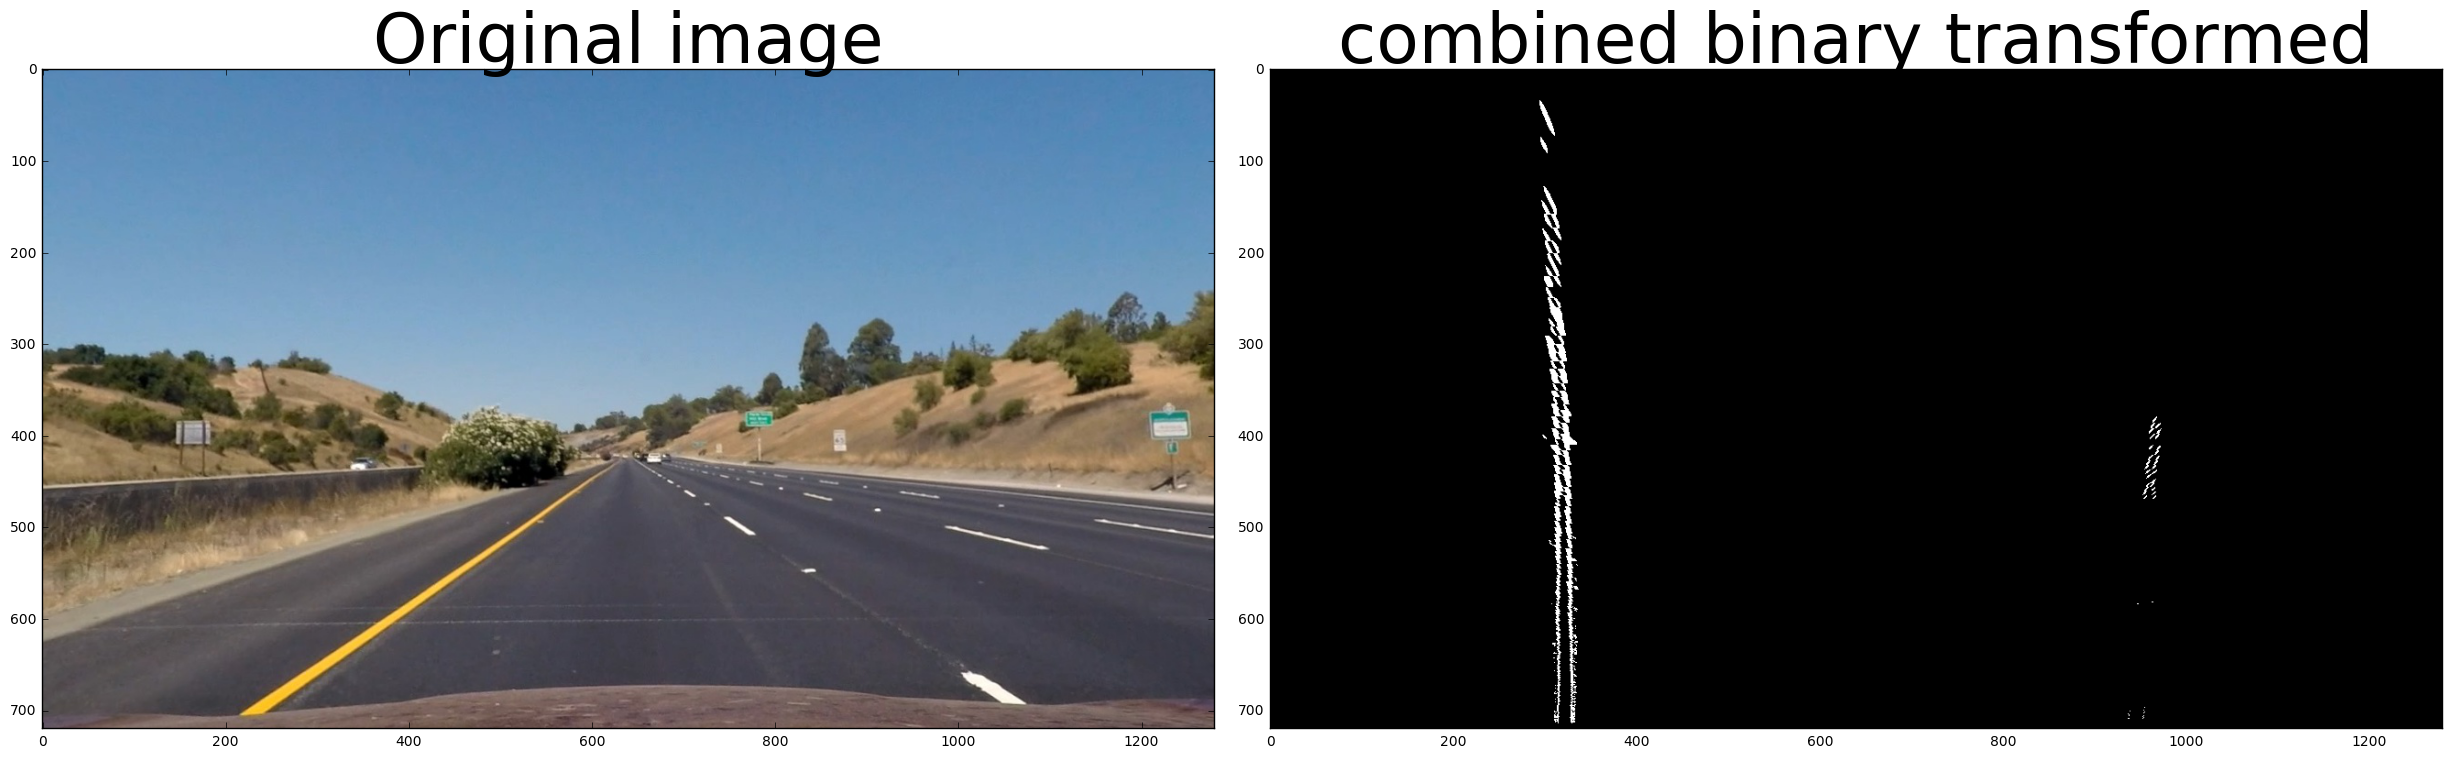

True

In [5]:
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
print(src, dst)
# Warp the image using OpenCV warpPerspective()
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(combined_binary, M, img_size)
plot(img,warped,o,"combined binary transformed")
cv2.imwrite('output_images/' + "binary_sx_transform" + ".jpg", cv2.cvtColor(warped*255, cv2.COLOR_GRAY2RGB))

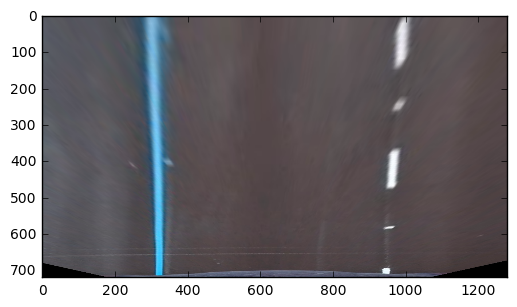

In [6]:
warpedi = cv2.warpPerspective(img, M, img_size)
plt.imshow(warpedi)
plt.show()